Import model data for comparison with observations

In [1]:
import netCDF4 as nc
import datetime as dt
import pandas as pd
from pandas import Series, DataFrame
import subprocess
import requests
import matplotlib.pyplot as plt
import cmocean
import numpy as np
import os
import glob
import dateutil as dutil
from salishsea_tools import viz_tools, places
import xarray as xr
from salishsea_tools import evaltools as et
from collections import OrderedDict

%matplotlib inline

In [2]:

start_date = dt.datetime(2023,1,1)
end_date = dt.datetime(2023,12,31)
flen=1 # number of days per model output file. always 1 for 201905 and 201812 model runs
namfmt='nowcast' # for 201905 and 201812 model runs, this should always be 'nowcast'
# filemap is dictionary of the form variableName: fileType, where variableName is the name
# of the variable you want to extract and fileType designates the type of 
# model output file it can be found in (usually ptrc_T for biology, grid_T for temperature and 
# salinity)
filemap={'PPDIAT':'prod_T','PPPHY':'prod_T'}
# fdict is a dictionary mappy file type to its time resolution. Here, 1 means hourly output
# (1h file) and 24 means daily output (1d file). In certain runs, multiple time resolutions 
# are available
fdict={'prod_T':24,'grid_T':24} #24 for hours averaged 

In [3]:
filemap

{'PPDIAT': 'prod_T', 'PPPHY': 'prod_T'}

In [4]:
#f=nc.Dataset('/results2/SalishSea/nowcast-green.202111/26jul23/SalishSea_1d_20230726_20230726_prod_T.nc')

In [5]:
#f.variables.keys()

In [6]:
PATH= '/results2/SalishSea/nowcast-green.202111/'

In [7]:
df2=pd.read_csv('/ocean/ksuchy/MOAD/analysis-karyn/notebooks/Evaluations/2023_SoG_PrimProd_DepthSpecific.csv')

In [8]:
df2

,Cruise,Sample Number,Date,Station,Z_lower,Z_upper,Original_Lat,Original_Long,Lat,Lon,Fo,GOPm (mmol O2 / m³ / h),JVPIIm (µmol photons / m³ / s),"Max. PhytoPP (using ɸe,c of 4; mmol C/m3/h )",Max. PhytoPP (using Redfield O:C; mmol C / m³ / h),aLHII,Daily Light Integral (mol photons / m2 / day),Total e- production (mol e- /m2/ day),Total C production *(mmol C/ m2/day ),Total C production * (g C /m2/day)
0,2023-002,2,16-Feb-23,GEO1,0,0,49 15.041 N,123 44.933 W,49.250000,-123.733333,1.0420,0.3557,0.3952,0.35568,0.273,0.01245,4.900,0.10,15.30,0.20
1,2023-002,11,17-Feb-23,BS-11,0,0,49 28.981 N,124 45.998 W,49.466667,-124.750000,0.8224,0.4182,0.4647,0.41823,0.321,0.01264,8.700,0.10,27.50,0.30
2,2023-002,22,17-Feb-23,12,5,5,49 43.568 N,124 40.834 W,49.716667,-124.666667,1.2140,0.6615,0.7350,0.66150,0.508,0.01493,8.700,0.10,32.40,0.40
3,2023-002,24,18-Feb-23,22,0,0,49 40.11 N,124 16.356 W,49.666667,-124.266667,1.0190,0.3513,0.3904,0.35136,0.270,0.01259,10.000,0.10,31.60,0.40
4,2023-002,25,18-Feb-23,2,0,0,49 23.987 N,124 9.495 W,49.383333,-124.150000,1.0140,0.7074,0.7860,0.70740,0.543,0.01515,10.000,0.20,38.10,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2023-029,287,12-Oct-23,12,0,0,49 43.593 N,124 40.668 W,49.716667,-124.666667,1.6590,1.3250,1.4720,1.32480,1.018,0.01917,12.908,0.25,61.86,0.74
84,2023-029,285,12-Oct-23,12,5,5,49 43.593 N,124 40.668 W,49.716667,-124.666667,1.7230,1.1720,1.3020,1.17180,0.900,0.01880,12.908,0.24,60.67,0.73
85,2023-029,284,12-Oct-23,12,10,10,49 43.593 N,124 40.668 W,49.716667,-124.666667,1.3840,0.8816,0.9795,0.88155,0.677,0.01707,12.908,0.22,55.08,0.66
86,2023-029,283,12-Oct-23,12,20,20,49 43.593 N,124 40.668 W,49.716667,-124.666667,0.9614,0.7239,0.8043,0.72387,0.556,0.01313,12.908,0.17,42.37,0.51


In [9]:
df2.rename(columns={'Date':'dtUTC'}, inplace=True)

In [10]:
df2['dtUTC'][0]

'16-Feb-23'

In [11]:
df2['dtUTC'] = df2['dtUTC'].apply(lambda x:
    dt.datetime.strptime(x, '%d-%b-%y'))

In [12]:
df2['dtUTC']

0    2023-02-16
1    2023-02-17
2    2023-02-17
3    2023-02-18
4    2023-02-18
        ...    
83   2023-10-12
84   2023-10-12
85   2023-10-12
86   2023-10-12
87   2023-10-13
Name: dtUTC, Length: 88, dtype: datetime64[ns]

In [13]:
data=et.matchData(df2,filemap,fdict,start_date,end_date,namfmt,PATH,flen,quiet=False,method='vertNet');

ftype=prod_T, are you sure? (if yes, add to list)


In [14]:
data

,Cruise,Sample Number,dtUTC,Station,Z_lower,Z_upper,Original_Lat,Original_Long,Lat,Lon,...,Daily Light Integral (mol photons / m2 / day),Total e- production (mol e- /m2/ day),Total C production *(mmol C/ m2/day ),Total C production * (g C /m2/day),j,i,mod_PPDIAT,mod_PPPHY,k_upper,k_lower
0,2023-002,2,2023-02-16,GEO1,0,0,49 15.041 N,123 44.933 W,49.250000,-123.733333,...,4.900,0.10,15.30,0.20,486,247,3.679722e-06,8.584354e-07,0,0
1,2023-002,11,2023-02-17,BS-11,0,0,49 28.981 N,124 45.998 W,49.466667,-124.750000,...,8.700,0.10,27.50,0.30,600,125,3.119322e-06,1.065053e-06,0,0
2,2023-002,22,2023-02-17,12,5,5,49 43.568 N,124 40.834 W,49.716667,-124.666667,...,8.700,0.10,32.40,0.40,643,169,1.846108e-06,7.240502e-07,4,4
3,2023-002,24,2023-02-18,22,0,0,49 40.11 N,124 16.356 W,49.666667,-124.266667,...,10.000,0.10,31.60,0.40,605,221,3.926109e-06,7.824627e-07,0,0
4,2023-002,25,2023-02-18,2,0,0,49 23.987 N,124 9.495 W,49.383333,-124.150000,...,10.000,0.20,38.10,0.50,542,203,4.269336e-06,8.297091e-07,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2023-029,285,2023-10-12,12,5,5,49 43.593 N,124 40.668 W,49.716667,-124.666667,...,12.908,0.24,60.67,0.73,643,169,3.813004e-06,7.212327e-07,4,4
84,2023-029,283,2023-10-12,12,20,20,49 43.593 N,124 40.668 W,49.716667,-124.666667,...,12.908,0.17,42.37,0.51,643,169,3.053954e-07,3.913864e-07,18,18
85,2023-029,229,2023-10-12,2,0,0,49 24.102 N,124 9.385 W,49.383333,-124.150000,...,13.400,2.96,738.91,8.87,542,203,6.073029e-06,9.016118e-07,0,0
86,2023-029,287,2023-10-12,12,0,0,49 43.593 N,124 40.668 W,49.716667,-124.666667,...,12.908,0.25,61.86,0.74,643,169,6.020887e-06,8.582093e-07,0,0


In [15]:
data.keys()

Index(['Cruise', 'Sample Number', 'dtUTC', 'Station', 'Z_lower', 'Z_upper',
       'Original_Lat', 'Original_Long', 'Lat', 'Lon', 'Fo',
       'GOPm (mmol O2 / m³ / h)', 'JVPIIm (µmol photons / m³ / s)',
       'Max. PhytoPP (using ɸe,c of 4; mmol C/m3/h )',
       'Max. PhytoPP (using Redfield O:C;  mmol C / m³ / h)', 'aLHII',
       'Daily Light Integral (mol photons / m2 / day)',
       'Total e- production (mol e- /m2/ day)',
       'Total C production *(mmol C/ m2/day )',
       'Total C production * (g C /m2/day)', 'j', 'i', 'mod_PPDIAT',
       'mod_PPPHY', 'k_upper', 'k_lower'],
      dtype='object')

In [16]:
cm1=cmocean.cm.thermal
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as bathy:
    bathylon=np.copy(bathy.variables['nav_lon'][:,:])
    bathylat=np.copy(bathy.variables['nav_lat'][:,:])
    bathyZ=np.copy(bathy.variables['Bathymetry'][:,:])

In [17]:
data.keys()

Index(['Cruise', 'Sample Number', 'dtUTC', 'Station', 'Z_lower', 'Z_upper',
       'Original_Lat', 'Original_Long', 'Lat', 'Lon', 'Fo',
       'GOPm (mmol O2 / m³ / h)', 'JVPIIm (µmol photons / m³ / s)',
       'Max. PhytoPP (using ɸe,c of 4; mmol C/m3/h )',
       'Max. PhytoPP (using Redfield O:C;  mmol C / m³ / h)', 'aLHII',
       'Daily Light Integral (mol photons / m2 / day)',
       'Total e- production (mol e- /m2/ day)',
       'Total C production *(mmol C/ m2/day )',
       'Total C production * (g C /m2/day)', 'j', 'i', 'mod_PPDIAT',
       'mod_PPPHY', 'k_upper', 'k_lower'],
      dtype='object')

In [18]:
data['mod_prod']=(data['mod_PPDIAT']+data['mod_PPPHY'])*86400*6.6 ## multiply by C:N ratio of 6.6?? Leave in mmol because obs are not in mg/g

In [19]:
data['obs_prod']=((data['Max. PhytoPP (using Redfield O:C;  mmol C / m³ / h)']))*12 ## To get value per day instead of per hour assuming productivity only during daylight

In [20]:
data

,Cruise,Sample Number,dtUTC,Station,Z_lower,Z_upper,Original_Lat,Original_Long,Lat,Lon,...,Total C production *(mmol C/ m2/day ),Total C production * (g C /m2/day),j,i,mod_PPDIAT,mod_PPPHY,k_upper,k_lower,mod_prod,obs_prod
0,2023-002,2,2023-02-16,GEO1,0,0,49 15.041 N,123 44.933 W,49.250000,-123.733333,...,15.30,0.20,486,247,3.679722e-06,8.584354e-07,0,0,2.587839,3.276
1,2023-002,11,2023-02-17,BS-11,0,0,49 28.981 N,124 45.998 W,49.466667,-124.750000,...,27.50,0.30,600,125,3.119322e-06,1.065053e-06,0,0,2.386098,3.852
2,2023-002,22,2023-02-17,12,5,5,49 43.568 N,124 40.834 W,49.716667,-124.666667,...,32.40,0.40,643,169,1.846108e-06,7.240502e-07,4,4,1.465607,6.096
3,2023-002,24,2023-02-18,22,0,0,49 40.11 N,124 16.356 W,49.666667,-124.266667,...,31.60,0.40,605,221,3.926109e-06,7.824627e-07,0,0,2.685016,3.240
4,2023-002,25,2023-02-18,2,0,0,49 23.987 N,124 9.495 W,49.383333,-124.150000,...,38.10,0.50,542,203,4.269336e-06,8.297091e-07,0,0,2.907680,6.516
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,2023-029,285,2023-10-12,12,5,5,49 43.593 N,124 40.668 W,49.716667,-124.666667,...,60.67,0.73,643,169,3.813004e-06,7.212327e-07,4,4,2.585603,10.800
84,2023-029,283,2023-10-12,12,20,20,49 43.593 N,124 40.668 W,49.716667,-124.666667,...,42.37,0.51,643,169,3.053954e-07,3.913864e-07,18,18,0.397333,6.672
85,2023-029,229,2023-10-12,2,0,0,49 24.102 N,124 9.385 W,49.383333,-124.150000,...,738.91,8.87,542,203,6.073029e-06,9.016118e-07,0,0,3.977219,26.496
86,2023-029,287,2023-10-12,12,0,0,49 43.593 N,124 40.668 W,49.716667,-124.666667,...,61.86,0.74,643,169,6.020887e-06,8.582093e-07,0,0,3.922736,12.216


In [21]:
data.keys()

Index(['Cruise', 'Sample Number', 'dtUTC', 'Station', 'Z_lower', 'Z_upper',
       'Original_Lat', 'Original_Long', 'Lat', 'Lon', 'Fo',
       'GOPm (mmol O2 / m³ / h)', 'JVPIIm (µmol photons / m³ / s)',
       'Max. PhytoPP (using ɸe,c of 4; mmol C/m3/h )',
       'Max. PhytoPP (using Redfield O:C;  mmol C / m³ / h)', 'aLHII',
       'Daily Light Integral (mol photons / m2 / day)',
       'Total e- production (mol e- /m2/ day)',
       'Total C production *(mmol C/ m2/day )',
       'Total C production * (g C /m2/day)', 'j', 'i', 'mod_PPDIAT',
       'mod_PPPHY', 'k_upper', 'k_lower', 'mod_prod', 'obs_prod'],
      dtype='object')

In [22]:
data=data.dropna()

In [23]:
print(data['obs_prod'].min())
print(data['obs_prod'].max())


0.948
1144.8000000000002


In [24]:
print(data['mod_prod'].min())
print(data['mod_prod'].max())

0.2379087707868166
21.816663641366176


In [25]:
def byDepth(ax,obsvar,modvar,lims):
    SI=et.varvarPlot(ax,data,obsvar,modvar,'Z_lower',(5,20),'z','m',('orange','darkturquoise','navy'))
    l=ax.legend(handles=SI)
    ax.set_xlabel('Log10 Observations (mmol C m$^{-3}$ d$^{-1}$)+0.001')
    ax.set_ylabel('Log10 Z2 Model (mmol C m$^{-3}$ d$^{-1}$)+0.001')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SI,l

(0.0, 40.0)

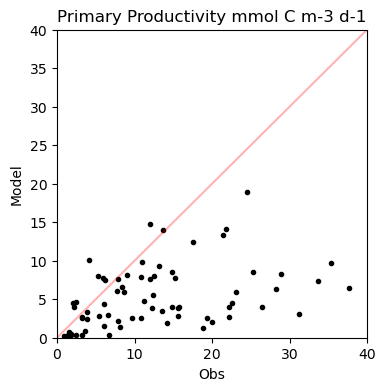

In [26]:
fig,ax=plt.subplots(1,1,figsize=(4,4))
fig.subplots_adjust(hspace=1)
ax.plot(data['obs_prod'],data['mod_prod'],'k.')
ax.set_title('Primary Productivity mmol C m-3 d-1')
ax.set_xlabel('Obs')
ax.set_ylabel('Model')
ax.plot((0,40),(0,40),'r-',alpha=.3)
ax.set_xlim(0,40)
ax.set_ylim(0,40)

Text(0.5, 1.0, 'Primary Productivity mmol C m-3 d-1 By Depth')

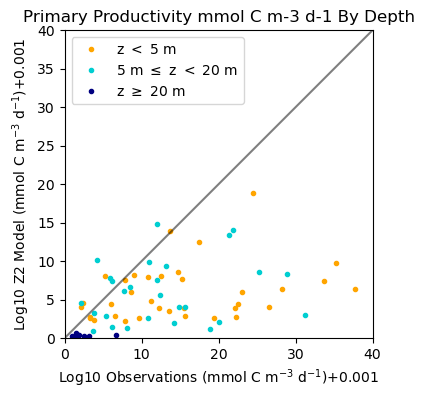

In [27]:
obsvar='obs_prod'
modvar='mod_prod'

fig, ax = plt.subplots(1,1,figsize = (4,4))
SI,l=byDepth(ax,obsvar,modvar,(0,40))
ax.set_title('Primary Productivity mmol C m-3 d-1 By Depth')

In [28]:
# define log transform function with slight shift to accommodate zero values
def logt(x):
    return np.log10(x+.001)

In [29]:
data['L10Productivity']=logt(data['obs_prod'])
data['L10mod_prod']=logt(data['mod_prod'])

/tmp/ipykernel_2969095/2370921417.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['L10Productivity']=logt(data['obs_prod'])
/tmp/ipykernel_2969095/2370921417.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['L10mod_prod']=logt(data['mod_prod'])


### Depth-specific Point by Point comparisions of model vs obs

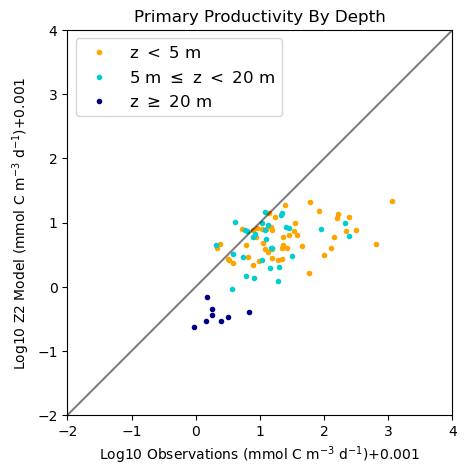

In [30]:
obsvar2='L10Productivity'
modvar2='L10mod_prod'

fig, ax = plt.subplots(1,1,figsize = (5,5))
SI,l=byDepth(ax,obsvar2,modvar2,(-2,4))
ax.set_title('Primary Productivity By Depth',fontsize=12)
ax.legend(frameon=True,fontsize=12)
#fig.savefig('SaanichLog10ModelvsObsProductivity.jpg',bbox_inches='tight')

In [47]:
ratio_modPPvsobsPP=data['L10mod_prod']/data['L10Productivity']

In [49]:
ratio_modPPvsobsPP.mean() 

## Compared to mod_diat/obs_diat HPLC biomass of 2.86 and mod_flag/obs_flag HPLC biomass of 3.45

0.7902708761672975

(-126.0, -121.0, 47.0, 51.0)

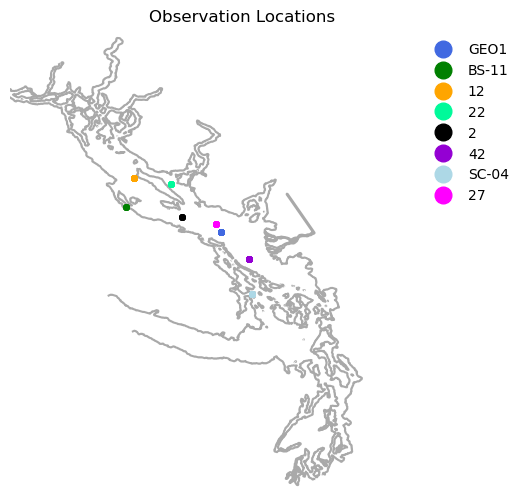

In [31]:
fig, ax = plt.subplots(1,1,figsize = (6,6))
with nc.Dataset('/ocean/ksuchy/MOAD/NEMO-forcing/grid/bathymetry_202108.nc') as grid:
    viz_tools.plot_coastline(ax, grid, coords = 'map',isobath=.1,color='darkgrey')
colors=('royalblue',
'green',
'orange',
'mediumspringgreen',
'black',
'darkviolet',
 'lightblue',
'fuchsia',
'firebrick','lime','darkgoldenrod','darkorange','deepskyblue','teal','darkgreen','darkblue','slateblue','purple')
datreg=dict()
for ind, iregion in enumerate(data.Station.unique()):
    datreg[iregion] = data.loc[data.Station==iregion]
    ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'o',
            color = colors[ind], label=iregion,markersize=4)
ax.set_ylim(47, 51)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14)
ax.legend(bbox_to_anchor=(1.1, 1),frameon=False,markerscale=3.)
ax.set_xlim(-126, -121);
ax.set_title('Observation Locations');
#ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left',frameon=False,markerscale=3.,fontsize=11)
ax.axis("off")
#fig.savefig('SalishSeaObservationLocations_noframe.jpg',bbox_inches='tight')

In [32]:
data['Month'] = data['dtUTC'].dt.month

/tmp/ipykernel_2969095/2600071084.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Month'] = data['dtUTC'].dt.month


In [33]:
data['Month'].max()

10

In [34]:
def byRegion(ax,obsvar,modvar,lims):
    SS=[]
    for ind, iregion in enumerate(data.Station.unique()):
        #ax.plot(datreg[iregion]['Lon'], datreg[iregion]['Lat'],'.',
                #color = colors[ind], label=iregion)
        SS0=et.varvarPlot(ax,datreg[iregion],obsvar,modvar,
                          cols=(colors[ind],),lname=iregion)
        SS.append(SS0)
    l=ax.legend(handles=[ip[0][0] for ip in SS])
    ax.set_xlabel('Log10 Observations (mmol C m$^{-3}$ d$^{-1}$)+0.001')
    ax.set_ylabel('Log10 Model (mmol C m$^{-3}$ d$^{-1}$)+0.001')
    ax.plot(lims,lims,'k-',alpha=.5)
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.set_aspect(1)
    return SS,l

In [35]:
#data['Month']=[ii.month for ii in data['dtUTC']]
DJF=data.loc[(data.Month==12)|(data.Month==1)|(data.Month==2)]
MAM=data.loc[(data.Month==3)|(data.Month==4)|(data.Month==5)]
JJA=data.loc[(data.Month==6)|(data.Month==7)|(data.Month==8)]
SON=data.loc[(data.Month==9)|(data.Month==10)|(data.Month==11)]

In [36]:
def bySeason(ax,obsvar,modvar,lims):
    for axi in ax:
        axi.plot(lims,lims,'k-')
        axi.set_xlim(lims)
        axi.set_ylim(lims)
        axi.set_aspect(1)
        axi.set_xlabel('Obs')
        axi.set_ylabel('Model')
    SS=et.varvarPlot(ax[0],DJF,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[0].set_title('Winter')
    SS=et.varvarPlot(ax[1],MAM,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[1].set_title('Spring')
    SS=et.varvarPlot(ax[2],JJA,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[2].set_title('Summer')
    SS=et.varvarPlot(ax[3],SON,obsvar,modvar,cols=('crimson','darkturquoise','navy'))
    ax[3].set_title('Autumn')
    return 

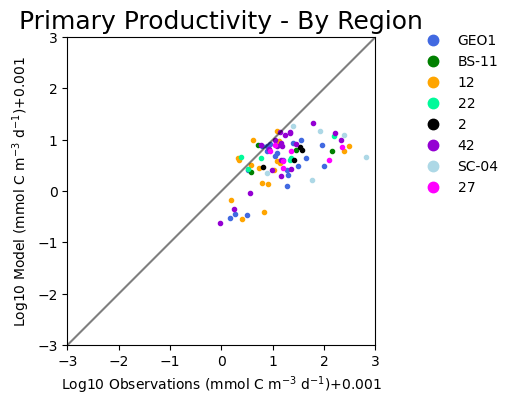

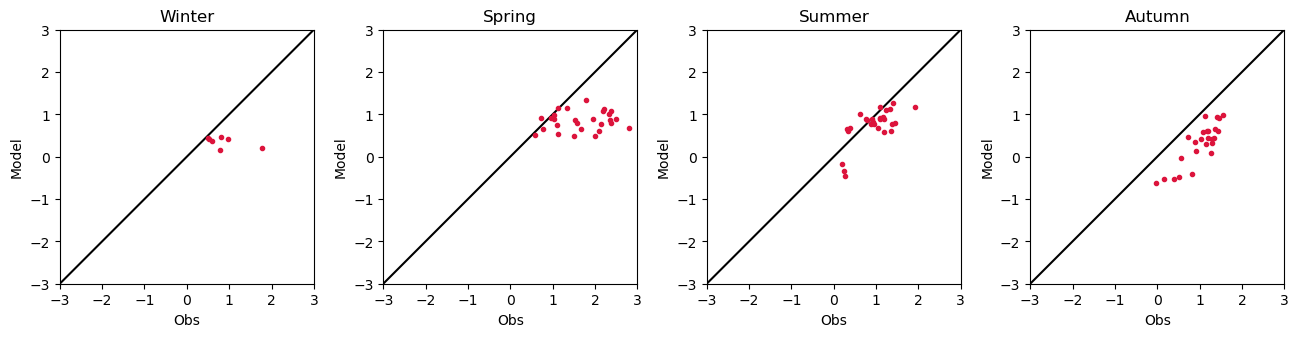

In [37]:
fig, ax = plt.subplots(1,1,figsize = (5,4))     
SS,l=byRegion(ax,'L10Productivity','L10mod_prod',(-3,3))
ax.set_title('Primary Productivity - By Region',fontsize=18)
ax.legend(bbox_to_anchor=(1.1, 1.05),frameon=False,markerscale=2.5)
#fig.savefig('SalishSeaDIMicroZoopEval_byregion_noLegend.jpg',bbox_inches='tight')





fig, ax = plt.subplots(1,4,figsize = (16,3.3))
bySeason(ax,'L10Productivity','L10mod_prod',(-3,3))

In [38]:
### These groupings will be used to calculate statistics. The keys are labels and
### the values are corresponding dataframe views
statsubs=OrderedDict({
                      'All':data,
                      'Winter':DJF,
                      'Spring':MAM,
                      'Summer':JJA,
                      'Autumn': SON,})
for iregion in data.Station.unique():
    statsubs[iregion]=datreg[iregion]
statsubs.keys()

odict_keys(['All', 'Winter', 'Spring', 'Summer', 'Autumn', 'GEO1', 'BS-11', '12', '22', '2', '42', 'SC-04', '27'])

In [39]:
# Defining variables needed for mesozooplankton evaluations
obsvar4='L10Productivity'
modvar4='L10mod_prod'
year=2023 #how do I calculate for all years?



In [40]:
statsDict={year:dict()}
statsDict[year]['MicroZ']=OrderedDict()
for isub in statsubs:
    print(isub)
    statsDict[year]['MicroZ'][isub]=dict()
    var=statsDict[year]['MicroZ'][isub]
    var['N'],var['mmean'],var['omean'],var['Bias'],var['RMSE'],var['WSS']=et.stats(statsubs[isub].loc[:,[obsvar4]],
                                                                     statsubs[isub].loc[:,[modvar4]])
tbl,tdf=et.displayStats(statsDict[year]['MicroZ'],level='Subset',suborder=list(statsubs.keys()))
tbl

#tbl.to_excel("SalishSeaMicrozoopEvalStats.xlsx")

All
Winter
Spring
Summer
Autumn
GEO1
BS-11
12
22
2
42
SC-04
27
